In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import warnings
import logging

from astropy.time import Time

from casacore import tables

### set logger...
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

console = logging.StreamHandler()
console.setLevel(logging.DEBUG)
console.setFormatter(formatter)
logger.addHandler(console)

def CasaGetNumField(tabpath):
    logger.info(f"loading field tab from {tabpath}...")
    fieldtab = tables.table(glob.glob(f"{tabpath}/FIELD"))
    field_count = fieldtab.getcol("SOURCE_ID").shape[0]
    logger.info(f"{field_count} source(s) found in {tabpath}")
    if field_count > 1:
        logger.warning("more than 1 source found! Will load the whole measurement set later...")
    fieldtab.close()
    return field_count

# def CasaGetNumAntenna(tabpath):
#     logger.info(f"loading antenna tab from {tabpath}...")
#     anttab = tables.table(glob.glob(f"{tabpath}/ANTENNA"))
#     ant_count = len(anttab.getcol("NAME"))
#     logger.info(f"{ant_count} antennas found in {tabpath}")
#     anttab.close()
#     return ant_count
def CasaGetNumAntenna(tab):
    # get from vis table directly instead of reading from Antenna table...
    ant = tab.getcol("ANTENNA1")
    return np.unique(ant).shape[0]
    

def CasaGetNumPol(tabpath):
    logger.info(f"loading pol tab from {tabpath}...")
    poltab = tables.table(glob.glob(f"{tabpath}/POLARIZATION"))
    pol_count = poltab.getcol("NUM_CORR")[0]
    logger.info(f"{pol_count} polarisations found in {tabpath}")
    poltab.close()
    return pol_count

def CasaGetSpt(tabpath):
    logger.info(f"loading spectrum tab from {tabpath}...")
    return tables.table(glob.glob(f"{tabpath}/SPECTRAL_WINDOW"))

def getnbl(nant, auto=True):
    return int(nant * (nant - 1) / 2 + nant) if auto else int(nant * (nant - 1) / 2)

def check_int(n, tol=1e-6):
    return True if abs(n - int(n)) <= tol else False

def find_sequence_overlap_slice(seq1, seq2, tol):
    seq1 = np.array(seq1); seq2 = np.array(seq2)
    
    overlap_idx1 = np.where(np.min(abs(seq1[:, None] - seq2), axis=1) < tol)[0]
    overlap_idx2 = np.where(np.min(abs(seq1[:, None] - seq2), axis=0) < tol)[0]
    
    ave_fact1 = (overlap_idx1[1:] - overlap_idx1[:-1]).mean()
    ave_fact2 = (overlap_idx2[1:] - overlap_idx2[:-1]).mean()
    
    logger.info(f"averaging factor: `seq1` - {ave_fact1:.2f}; `seq2` - {ave_fact2:.2f}")
    
    assert check_int(ave_fact1), f"No evenly sample data found in `seq1`... please check `tol`..."
    assert check_int(ave_fact2), f"No evenly sample data found in `seq2`... please check `tol`..."
    
#     logger.info(f"averaging factor: ` seq1` - {int(ave_fact1)}, `seq2` - {int(ave_fact2)}")
    
    assert ave_fact1 == 1 or ave_fact2 == 1, "Cannot handle the data with no averaging factor equals to 1..."
    
    logger.info("determine the overlapping region between two sequences...")
    if (overlap_idx1[-1] + int(ave_fact1)) > len(seq1) or overlap_idx2[-1] + int(ave_fact2) > len(seq2):
        slice1 = slice(overlap_idx1[0], overlap_idx1[-1])
        slice2 = slice(overlap_idx2[0], overlap_idx2[-1])
    else:
        slice1 = slice(overlap_idx1[0], overlap_idx1[-1] + int(ave_fact1))
        slice2 = slice(overlap_idx2[0], overlap_idx2[-1] + int(ave_fact2))
        
    logger.info(
        "{} samples from `seq1` and {} samples from `seq2` have been selected".format(
            slice1.stop - slice1.start, slice2.stop - slice2.start
        )
    )
        
    return slice1, slice2, int(ave_fact1), int(ave_fact2)

def find_bl_bool(ant1, ant2, bl_array, zero_index=False):
    if ant1 > ant2: ant1, ant2 = ant2, ant1
        
    if not zero_index:
        ant1 -= 1; ant2 -= 1
        
    return ((bl_array[0] == ant1) & (bl_array[1] == ant2))


def waterfall_compare(data1, data2, bl_arr1, bl_arr2, ant1, ant2, metrics="phase"):
    logger.info(f"comapring {metrics} for baseline {ant1}-{ant2}")
    
    bl_idx1 = find_bl_bool(ant1, ant2, bl_arr1)
    bl_idx2 = find_bl_bool(ant1, ant2, bl_arr2)
    
    data1_bl = data1[:, bl_idx1, :].squeeze()
    data2_bl = data2[:, bl_idx2, :].squeeze()
    
    if metrics == "phase":
        phase_diff = np.angle(data1_bl, deg=True) - np.angle(data2_bl, deg=True)
        tmp_data = np.array([phase_diff-360, phase_diff, phase_diff+360])
        min_idx = np.argmin(np.abs(tmp_data), axis=0)
        data_comp = np.take_along_axis(tmp_data, np.expand_dims(min_idx, axis=0), axis=0)[0]
        
    else:
        data_comp = np.abs(data1_bl) / np.abs(data2_bl)
        
    return data_comp

def plot_waterfall_compare(waterfall, ax=None, metrics="phase"):
    if ax is None:
        fig = plt.figure(figsize=(4, 4)); ax = fig.add_subplot(1, 1, 1)
    if metrics == "phase": vmin, vmax, cmap = -10, 10, "bwr"
    else: vmin, vmax, cmap = 0.1, 0.16, "PRGn"
    
    ax.imshow(
        waterfall, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap
    )
    
    return ax

def plot_line_comp(data1, data2, bl_arr1, bl_arr2, ant1, ant2, label1, label2, t=None, f=None):
    # both data1 and data2 have 3 dimensions - nt, nbl, nchan
    if (t is None and f is None) or (t is not None and f is not None):
        raise ValueError("Either `t` or `f` should be an extact number...")
    
    fig = plt.figure(figsize=(12, 4), dpi=100)
    
    bl_idx1 = find_bl_bool(ant1, ant2, bl_arr1)
    bl_idx2 = find_bl_bool(ant1, ant2, bl_arr2)
    
    data1_bl = data1[:, bl_idx1, :].squeeze()
    data2_bl = data2[:, bl_idx2, :].squeeze()
    
    if f is None: # plotting for frequency
        data1_sel = data1_bl[t, :]
        data2_sel = data2_bl[t, :]
        xlabel = "Channel"
        title = f"INT{t}"
    else:
        data1_sel = data1_bl[:, f]
        data2_sel = data2_bl[:, f]
        xlabel = "ASKAP Integration"
        title = f"CHAN{f}"
        
    ax = fig.add_subplot(1, 2, 1) # for phase
    ax.plot(np.angle(data1_sel, deg=True), color="green", lw=3, alpha=0.8, label=label1)
    ax.plot(np.angle(data2_sel, deg=True), ".", color="red", markersize=4, label=label2)
    ax.set_xlabel(xlabel); ax.set_ylabel("Phase (deg)")
    ax.set_xlim(-1, len(data1_sel)); ax.set_ylim(-200, 200)
    ax.set_title(f"Phase for ak{ant1}-ak{ant2} [{title}]")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2) # for amplitude
    ax.plot(np.abs(data1_sel), color="green", lw=3, alpha=0.8, label=label1)
    ax.plot(np.abs(data2_sel), ".", color="red", markersize=4, label=label2)
    ax.set_xlabel(xlabel); ax.set_ylabel("Amplitude")
    ax.set_xlim(-1, len(data1_sel)); 
    ax.set_title(f"Amplitude for ak{ant1}-ak{ant2} [{title}]")
    

def load_measurement_sets(craco_tab_path, hw_tab_path):

    cracotab = tables.table(craco_tab_path)
    hwtab = tables.table(hw_tab_path)

    craco_nfield = CasaGetNumField(craco_tab_path)
    hw_nfield = CasaGetNumField(hw_tab_path)

    # craco_nant = CasaGetNumAntenna(craco_tab_path)
    # logger.warning("Number of antenna stored in craco measurement sets is wrong... Update to 30...")
    # craco_nant = 30
    # hw_nant = CasaGetNumAntenna(hw_tab_path)
    craco_nant = CasaGetNumAntenna(cracotab)
    hw_nant = CasaGetNumAntenna(hwtab)

    logger.info(f"number of antennas: craco - {craco_nant}; askap hardware - {hw_nant}")

    craco_npol = CasaGetNumPol(craco_tab_path)
    hw_npol = CasaGetNumPol(hw_tab_path)

    cracospttab = CasaGetSpt(craco_tab_path)
    hwspttab = CasaGetSpt(hw_tab_path)

    assert craco_npol == 1, "Cannot handle non-polsum data..."

    craco_nbl = getnbl(craco_nant)
    hw_nbl = getnbl(hw_nant)

    logger.info(f"number of baselines: craco - {craco_nbl}; askap hardware - {hw_nbl}")

    cracorawfreq = cracospttab.getcol("CHAN_FREQ").squeeze()
    hwrawfreq = hwspttab.getcol("CHAN_FREQ").squeeze()

    cracorawcwid = cracospttab.getcol("CHAN_WIDTH").squeeze().mean()
    hwrawcwid = hwspttab.getcol("CHAN_WIDTH").squeeze().mean()

    craco_nchan = cracorawfreq.shape[0]
    hw_nchan = hwrawfreq.shape[0]

    logger.info(f"number of channels: craco - {craco_nchan}; askap hardware - {hw_nchan}")
    logger.info(f"channel width: craco - {cracorawcwid/1e6:.2f} MHz; askap hardware - {hwrawcwid/1e6:.2f} MHz")

    logger.info("extracting data from tables...")
    cracodata_raw = cracotab.getcol("DATA")
    hwdata_raw = hwtab.getcol("DATA")
    logger.debug("data shape for craco - {}".format(cracodata_raw.shape))
    logger.debug("data shape for askap hardware - {}".format(hwdata_raw.shape))
    
    logger.info("extracting UVW coordinate information from tables...")
    craco_uvw_raw = cracotab.getcol("UVW")
    hw_uvw_raw = hwtab.getcol("UVW")
    logger.debug("uvw data shape for craco - {}".format(craco_uvw_raw.shape))
    logger.debug("uvw data shape for askap hardware - {}".format(hw_uvw_raw.shape))

    ### NEW PART!!!
    logger.info("reshaping the data...")
    cracodata = cracodata_raw.reshape(-1, craco_nbl, craco_nchan, craco_npol)
    hwdata = hwdata_raw.reshape(-1, hw_nbl, hw_nchan, hw_npol)
    logger.info(f"new data shape - craco: {cracodata.shape}; askap hardware: {hwdata.shape}")
    cracouvw = craco_uvw_raw.reshape(-1, craco_nbl, 3)
    hwuvw = hw_uvw_raw.reshape(-1, hw_nbl, 3)
    logger.info(f"new uvw data shape - craco: {cracouvw.shape}; askap hardware: {hwuvw.shape}")

    ### need a copy of reshaped data for further investigation
#     hwdata_raw = hwdata.copy()
#     cracodata_raw = cracodata.copy()
#     hwuvw_raw = hwuvw.copy()
#     cracouvw_raw = cracouvw.copy()

    # UTCTAI_DIFF = 37
#     UTCTAI_DIFF = 32
#     OFFSET = 4.921343999906779 # t1
#     OFFSET = 5.031936000093222 # t2
#     OFFSET = 4.866047999813557 # t3
#     OFFSET = 5.087232000186444 # t4
#     OFFSET = 4.976640000000001 # t5 
#     OFFSET = 5.0042880000466115 #   
    OFFSET = 0 # => No offset needed as both CRACO and hardware data are in UTC
    logger.warning("craco and askap hardware are using different time system...")

    # cracorawtime = np.unique(cracotab.getcol("TIME")) - UTCTAI_DIFF
    cracorawtime = Time(
        np.unique(cracotab.getcol("TIME")) / 3600 / 24, 
        format="mjd", scale="utc"
    ).utc.value * 3600 * 24
    cracorawtime = cracorawtime + OFFSET  #<============= apply the offset to check
    hwrawtime = np.unique(hwtab.getcol("TIME"))

    craco_nt = cracorawtime.shape[0]
    hw_nt = hwrawtime.shape[0]
    
    logger.info(f"number of integrations - craco: {craco_nt}; askap hardware: {hw_nt}")

    assert craco_nt == cracodata.shape[0], "different number of integrations found in craco data..."
    assert hw_nt == hwdata.shape[0], "different number of integrations found in craco data..."

    logger.info(f"number of integrations - craco: {craco_nt}; askap hardware: {hw_nt}")

    cracorawtr = cracotab.getcol("EXPOSURE").mean()
    hwrawtr = hwtab.getcol("EXPOSURE").mean()

    logger.info(f"time resolution: craco - {cracorawtr:.2f} s; askap hardware - {hwrawtr:.2f} s")

    logger.info("get baseline information...") # they are sorted in the same order for different integration...

    ###
    craco_bl = np.array([
        cracotab.getcol("ANTENNA1")[:craco_nbl], cracotab.getcol("ANTENNA2")[:craco_nbl]
    ])
    hw_bl = np.array([
        hwtab.getcol("ANTENNA1")[:hw_nbl], hwtab.getcol("ANTENNA2")[:hw_nbl]
    ])

    cracorawfreq_s = cracorawfreq - cracorawcwid / 2
    hwrawfreq_s = hwrawfreq - hwrawcwid / 2

    cracofs, hwfs, cracofa, hwfa = find_sequence_overlap_slice(
        cracorawfreq_s, hwrawfreq_s, cracorawcwid / 2 # 100 Hz
    )

    assert hwfa == 1, "there should be no averaging for askap hardware data..."
    logger.info(f"select {cracofs} from craco and {hwfs} from askap hardware data")

    logger.info("extracting overlapping data on frequency axis...")
    cracodata = cracodata[:, :, cracofs, :].copy()
    hwdata = hwdata[:, :, hwfs, :].copy()
    logger.info(f"shape of overlapping data: craco - {cracodata.shape}; askap hardware - {hwdata.shape}")

    logger.info("averaging craco data on frequency axis...")
    cracodata_tmp = cracodata.reshape(craco_nt, craco_nbl, -1, cracofa, craco_npol)
    cracodata = cracodata_tmp.mean(axis=3)
    logger.info(f"shape of data after frequency averaging: craco - {cracodata.shape}; askap hardware - {hwdata.shape}")

    central_freq = hwrawfreq[hwfs]
    nchan = central_freq.shape[0]

    cracorawtime_s = cracorawtime - cracorawtr / 2
    hwrawtime_s = hwrawtime - hwrawtr / 2

    cracots, hwts, cracota, hwta = find_sequence_overlap_slice(
        cracorawtime_s, hwrawtime_s, cracorawtr / 2 
    )

    assert hwta == 1, "there should be no averaging for askap hardware data..."
    logger.info(f"select {cracots} from craco and {hwts} from askap hardware data")

    logger.info("extracting overlapping data on time axis...")
    cracodata = cracodata[cracots, :, :, :].copy()
    hwdata = hwdata[hwts, :, :, :].copy()
    ### add code for averaging uvw data...
    cracouvw = cracouvw[cracots, :, :].copy()
    hwuvw = hwuvw[hwts, :, :].copy()

    logger.info(f"shape of overlapping data: craco - {cracodata.shape}; askap hardware - {hwdata.shape}")
    logger.info(f"shape of overlapping uvw data: craco - {cracouvw.shape}; askap hardware - {hwuvw.shape}")

    logger.info("averaging craco data on time axis...")
    cracodata_tmp = cracodata.reshape(-1, cracota, craco_nbl, nchan, craco_npol)
    cracodata = cracodata_tmp.mean(axis=1)
    cracouvw_tmp = cracouvw.reshape(-1, cracota, craco_nbl, 3)
    cracouvw = cracouvw_tmp.mean(axis=1)
    logger.info(f"shape of data after time averaging: craco - {cracodata.shape}; askap hardware - {hwdata.shape}")
    logger.info(f"shape of overlapping uvw data: craco - {cracouvw.shape}; askap hardware - {hwuvw.shape}")

    central_time = hwrawtime[hwts]
    nt = central_time.shape[0]

    logger.info("summing up polarisation (XX+YY)...")
    if hw_npol == 4: #XX, XY, YX, YY
        hwdata = hwdata[..., (0, -1)].sum(axis=-1)
    elif hw_npol == 2:
        hwdata = hwdata.sum(axis=-1)
        
    logger.info("drop polarisation dimension...")
    cracodata = cracodata[..., 0].copy()

    logger.info(f"shape of data now: craco - {cracodata.shape}; askap hardware - {hwdata.shape}")

    cracotab.close(); hwtab.close()

    return cracodata, hwdata, cracouvw, hwuvw, central_freq, central_time, craco_bl, hw_bl, craco_nant, craco_nchan


### only extract corresponding baselines to make comparision more easily
def find_hwbl_overlap(craco_bl, hw_bl):
    hw_bl_sel = np.full((craco_bl.shape[-1],), -1)
    for idx in range(craco_bl.shape[-1]):
        ant1 = craco_bl[0][idx]; ant2 = craco_bl[1][idx]
        hw_bl_sel[idx] = np.where((hw_bl[0] == ant1) & (hw_bl[1] == ant2))[0][0]
        
    return hw_bl_sel

def find_crosscor(bl):
    bl_sel = np.full((bl.shape[-1],), False)
    for idx in range(bl.shape[-1]):
        ant1, ant2 = bl[:, idx]
        if ant1 != ant2:
            bl_sel[idx] = True
    return bl_sel

def find_ant_bl(bl, ant, zero_index=False):
    if not zero_index: ant -= 1
        
    bl_sel = np.full((bl.shape[-1],), False)
    for idx in range(bl.shape[-1]):
        ant1, ant2 = bl[:, idx]
        if ant1 == ant or ant2 == ant:
            bl_sel[idx] = True
    return bl_sel

def overall_plot(nrows, ncols, cracodata, hwdata, nchan, parameter="Phase", v_min=0, v_max=5):
    fig, axs = plt.subplots(nrows, ncols, figsize=(40, 40))  # Adjust the figure size as needed
    assert (parameter == "Phase" or parameter == "Amplitude"), "Paramter should be 'Phase' or 'Amplitude'."
    median_difference = []
    for i in range(nrows):
        for j in range(ncols):
            if i > j:
                axs[j, i].axis('off')
                continue
            if parameter == "Phase":
                phase_diff = []
                for k in range(nchan):
                    phase_diff.append(np.array(np.angle(cracodata[:,int(i*nrows+j-i*(i+1)/2),k])
                                               - np.angle(hwdata[:,overlap_hwbl[int(i*nrows+j-i*(i+1)/2)],k])))
                median_difference.append(np.median(np.array(phase_diff)))
                c = axs[j,i].imshow(
                    np.array(phase_diff), aspect="auto", 
                    vmin=-np.pi, vmax=np.pi,
                    cmap="coolwarm"
                )
            elif parameter == "Amplitude":
                amp_ratio = []
                for k in range(nchan):
                    amp_ratio.append(np.array(abs(cracodata[:,int(i*nrows+j-i*(i+1)/2),k])/
                                              abs(hwdata[:,overlap_hwbl[int(i*nrows+j-i*(i+1)/2)],k])))
                median_difference.append(np.median(np.array(amp_ratio)))
                c = axs[j,i].imshow(
                    np.array(amp_ratio), aspect="auto",
                    vmin=v_min, vmax=v_max,
                )
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])
            if j == nrows - 1:
                axs[j,i].set_xlabel(i, fontsize=20)
            if i == 0:
                axs[j,i].set_ylabel(j+1, fontsize=20)
    statistical_score = 1-np.nanstd(median_difference)
    fig.text(0.5,-0.01,"ANTENNA", ha='center', va='center', fontsize=40)
    fig.text(-0.01,0.5,"ANTENNA", ha='center', va='center', rotation='vertical', fontsize=40)
    cbar_ax = fig.add_axes([0.92, 0.17, 0.018, 0.8])
    cbar = fig.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=36)
    fig.text(0.65,0.55,f'Statistical score: {statistical_score:.4f}',fontsize=48)
    fig.tight_layout()
    figure_name = "/data/craco/craco/lee369/SB062513_" + parameter + ".png"
    plt.savefig(figure_name)
    plt.show()
    
def plot_one_baseline(antenna1, antenna2, cracodata, hwdata, nant, nchan):
    if antenna1 > antenna2:
        antenna1, antenna2 = antenna2, antenna1
    elif antenna1 == antenna2:
        print("antenna numbers of a baseline should not be the same")
        return
    amp_ratio = []
    phase_diff = []
    baseline_pair_index = int(antenna1*nant+antenna2-antenna1*(antenna1+1)/2)
    for i in range(nchan):
        amp_ratio.append(np.array(abs(cracodata[:,baseline_pair_index,i])/abs(hwdata[:,overlap_hwbl[baseline_pair_index],i])))
        phase_diff.append(np.array((np.angle(cracodata[:,baseline_pair_index,i]) - np.angle(hwdata[:,overlap_hwbl[baseline_pair_index],i]))))
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(
        np.array(phase_diff), aspect="auto", 
        vmin=-np.pi, vmax=np.pi,
        cmap="coolwarm"
    )
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(
        np.array(amp_ratio), aspect="auto",
        cmap="viridis"
    )
    ax1.set_title("Phase difference", fontsize=20)
    ax2.set_title("Amplitude Ratio", fontsize=20)
    fig.tight_layout()
    plt.show()

def uvw_plot(cracouvw, hwuvw, overlap_hwbl, limit=6, dimension=3):
    fig = plt.figure(figsize=(18, 5))
    label = ["u", "v", "w"]
    for i in range(dimension):
        ax = fig.add_subplot(1, dimension, i+1)
        for j,e in enumerate(overlap_hwbl):
            if np.all(hwuvw[:, e, i] > 0):
                plt.plot((cracouvw[:,j,i] - hwuvw[:, e, i])/hwuvw[:, e, i]*100)
        ax.set_ylim(-limit,limit)
        ax.set_title(label[i], fontsize=22)
    fig.text(0,0.5,"Percentage difference", ha='center', va='center', rotation='vertical', fontsize=24)
    fig.tight_layout()
    plt.show()

In [2]:
#The path to the ms file
craco_tab_path = "/data/craco/craco/lee369/SB062513_b10.uvw.ms/"
hw_tab_path = "/CRACO/DATA_00/craco/wan342/craco_develop/CRACO-251/data/SB062513/hw/2024-05-22_174304_10.ms/"

cracodata, hwdata, cracouvw, hwuvw, central_freq, central_time, craco_bl, hw_bl, nant, nchan = load_measurement_sets(craco_tab_path, hw_tab_path)
overlap_hwbl = find_hwbl_overlap(craco_bl, hw_bl)

2024-06-04 13:53:34,545 - __main__ - INFO - loading field tab from /data/craco/craco/lee369/SB062513_b10.uvw.ms/...
2024-06-04 13:53:34,563 - __main__ - INFO - 1 source(s) found in /data/craco/craco/lee369/SB062513_b10.uvw.ms/
2024-06-04 13:53:34,563 - __main__ - INFO - loading field tab from /CRACO/DATA_00/craco/wan342/craco_develop/CRACO-251/data/SB062513/hw/2024-05-22_174304_10.ms/...
2024-06-04 13:53:34,565 - __main__ - INFO - 1 source(s) found in /CRACO/DATA_00/craco/wan342/craco_develop/CRACO-251/data/SB062513/hw/2024-05-22_174304_10.ms/
2024-06-04 13:53:34,701 - __main__ - INFO - number of antennas: craco - 22; askap hardware - 36
2024-06-04 13:53:34,702 - __main__ - INFO - loading pol tab from /data/craco/craco/lee369/SB062513_b10.uvw.ms/...
2024-06-04 13:53:34,704 - __main__ - INFO - 1 polarisations found in /data/craco/craco/lee369/SB062513_b10.uvw.ms/
2024-06-04 13:53:34,704 - __main__ - INFO - loading pol tab from /CRACO/DATA_00/craco/wan342/craco_develop/CRACO-251/data/SB0

Successful readonly open of default-locked table /data/craco/craco/lee369/SB062513_b10.uvw.ms/: 23 columns, 10905312 rows
Successful readonly open of default-locked table /CRACO/DATA_00/craco/wan342/craco_develop/CRACO-251/data/SB062513/hw/2024-05-22_174304_10.ms/: 22 columns, 48618 rows
Successful readonly open of default-locked concatenated tables ['/data/craco/craco/lee369/SB062513_b10.uvw.ms//FIELD'] : 9 columns, 1 rows
Successful readonly open of default-locked concatenated tables ['/CRACO/DATA_00/craco/wan342/craco_develop/CRACO-251/data/SB062513/hw/2024-05-22_174304_10.ms//FIELD'] : 9 columns, 1 rows
Successful readonly open of default-locked concatenated tables ['/data/craco/craco/lee369/SB062513_b10.uvw.ms//POLARIZATION'] : 4 columns, 1 rows
Successful readonly open of default-locked concatenated tables ['/CRACO/DATA_00/craco/wan342/craco_develop/CRACO-251/data/SB062513/hw/2024-05-22_174304_10.ms//POLARIZATION'] : 4 columns, 1 rows
Successful readonly open of default-locked co

2024-06-04 13:54:30,834 - __main__ - DEBUG - data shape for askap hardware - (48618, 288, 4)
2024-06-04 13:54:30,841 - __main__ - INFO - extracting UVW coordinate information from tables...
2024-06-04 13:54:31,170 - __main__ - DEBUG - uvw data shape for craco - (10905312, 3)
2024-06-04 13:54:31,172 - __main__ - DEBUG - uvw data shape for askap hardware - (48618, 3)
2024-06-04 13:54:31,174 - __main__ - INFO - reshaping the data...
2024-06-04 13:54:31,178 - __main__ - INFO - new data shape - craco: (43104, 253, 240, 1); askap hardware: (73, 666, 288, 4)
2024-06-04 13:54:31,180 - __main__ - INFO - new uvw data shape - craco: (43104, 253, 3); askap hardware: (73, 666, 3)
2024-06-04 13:54:31,181 - __main__ - WARNING - craco and askap hardware are using different time system...
2024-06-04 13:54:31,617 - __main__ - INFO - number of integrations - craco: 43104; askap hardware: 73
2024-06-04 13:54:31,622 - __main__ - INFO - number of integrations - craco: 43104; askap hardware: 73
2024-06-04 13

/data/craco/craco/tmpdir/ipykernel_4037797/1603916428.py:432: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


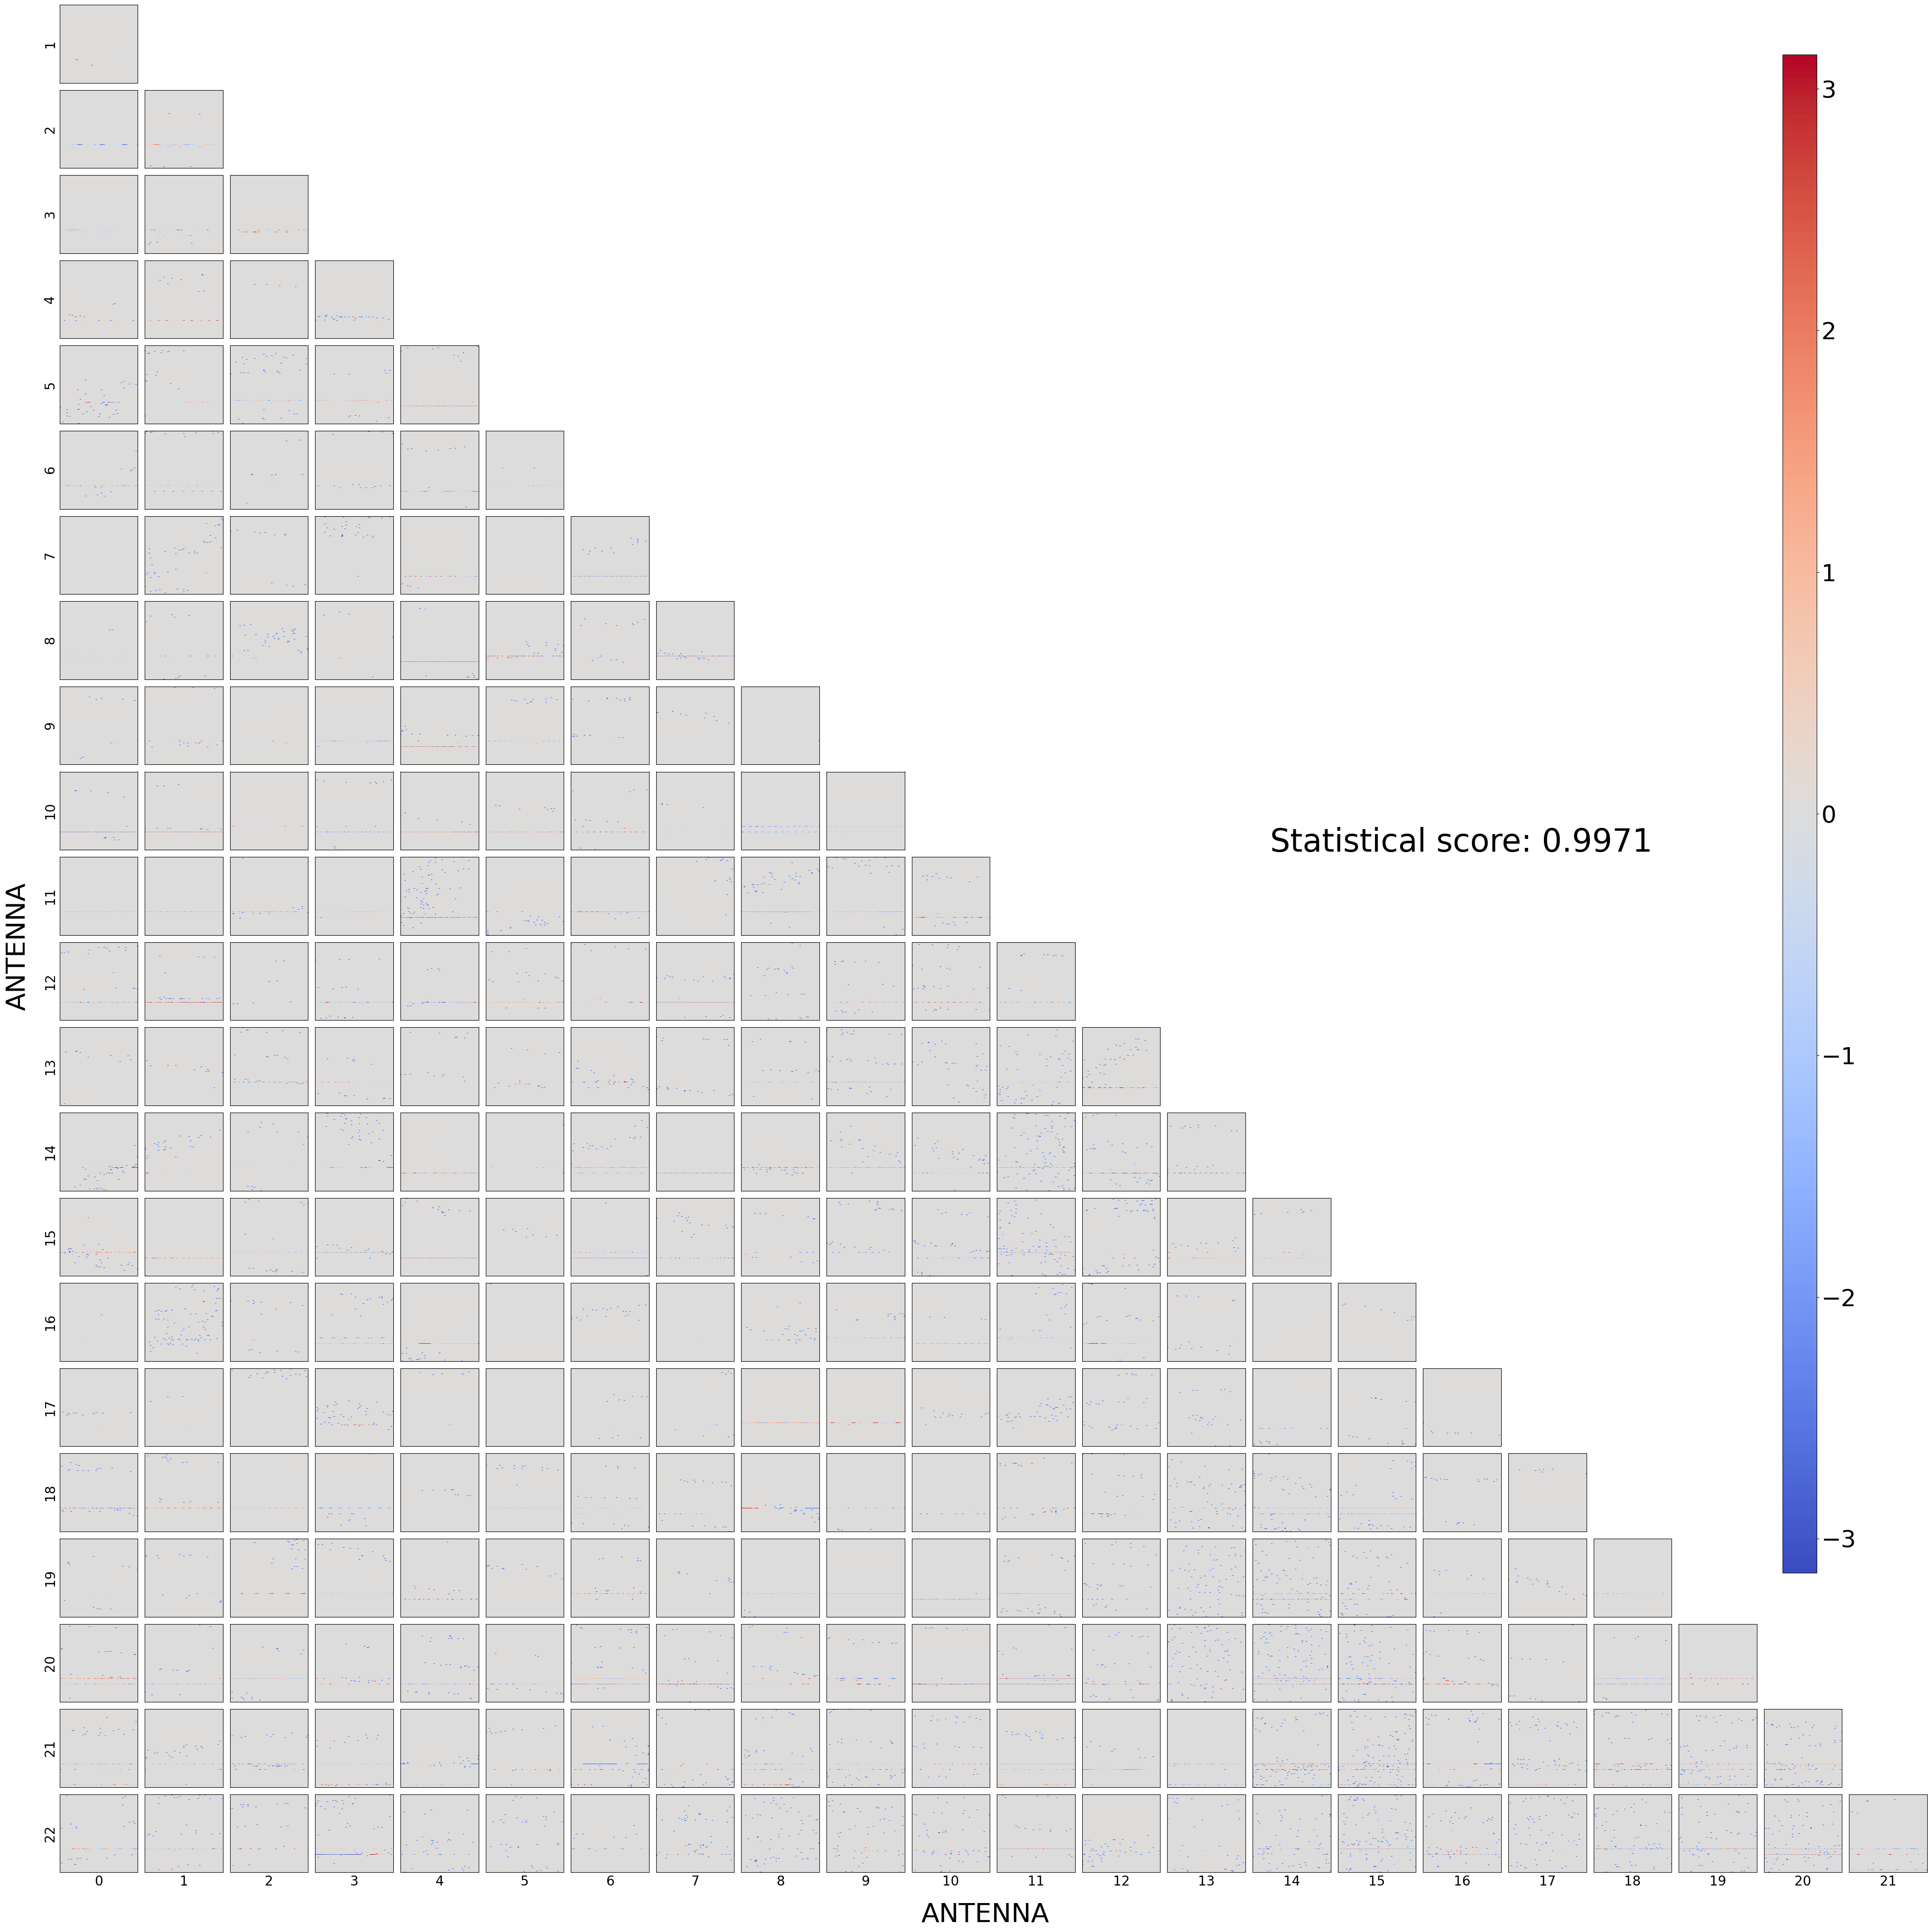

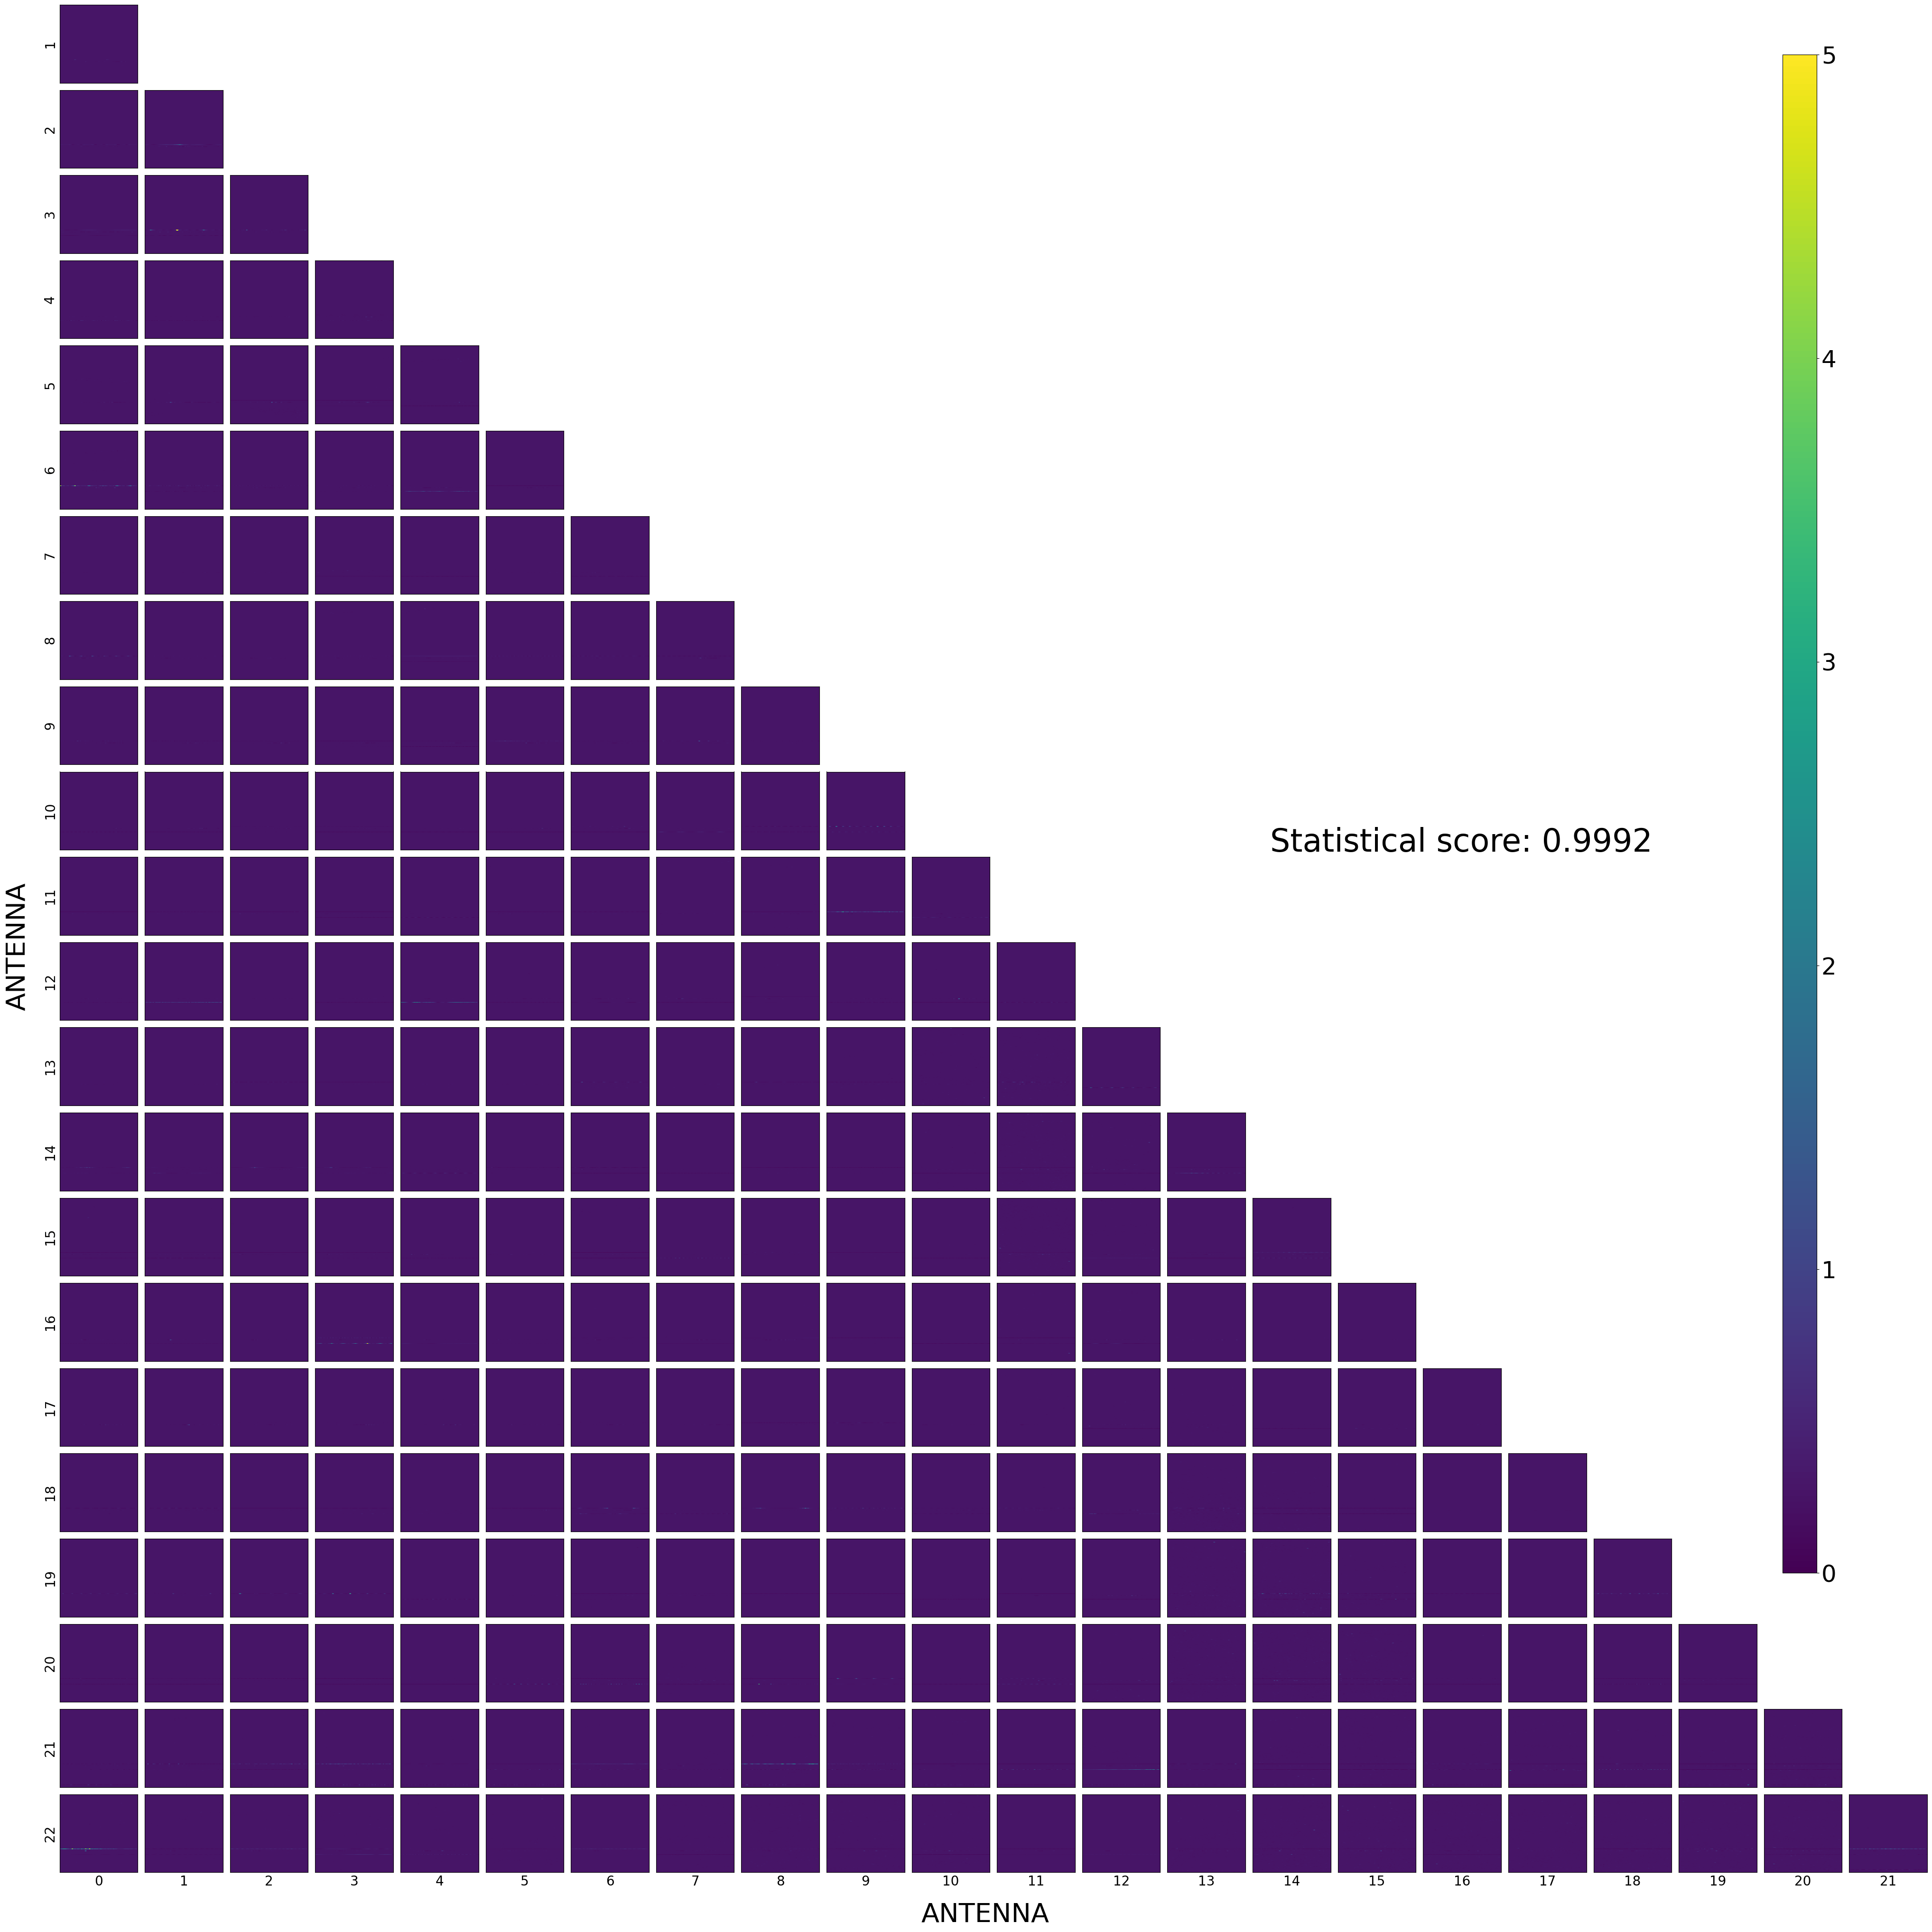

In [22]:
#Plot the Phase difference between CRACO and hardware data
overall_plot(nant, nant, cracodata, hwdata, nchan, "Phase")
#Plot the Amplitude ratio between CRACO and hardware data
overall_plot(nant, nant, cracodata, hwdata, nchan, "Amplitude")

#Plot the percentage difference of uvw between CRACO and hardware data
#uvw_plot(cracouvw, hwuvw, overlap_hwbl)

#Plot the Phase difference and Amplitude ratio of a specific baseline by inputting ANTENNA1 and ANTENNA2
#plot_one_baseline(10,12,cracodata,hwdata,nant,nchan)

## Supplementary 

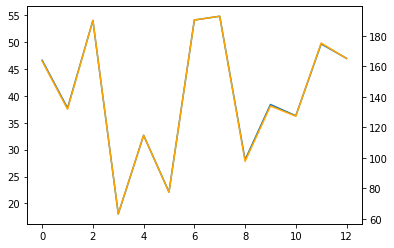

In [118]:
#Plot the amplitude of one specific baseline at one given channel
antenna1 = 0
antenna2 = 10
nant = 29 #number of antennas
channel_number = 100
baseline_pair_index = int(antenna1*nant+antenna2-antenna1*(antenna1+1)/2)
plt.plot(abs(cracodata[:,baseline_pair_index,channel_number]))
plt.twinx()
plt.plot(abs(hwdata[:,overlap_hwbl[baseline_pair_index],channel_number]),color="orange")
plt.show()

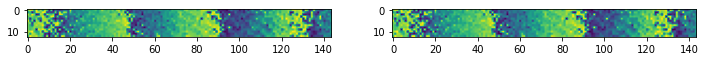

In [119]:
#Plot the amplitude or phase of one specific baseline at full channel
antenna1 = 0
antenna2 = 10
baseline_pair_index = int(antenna1*nant+antenna2-antenna1*(antenna1+1)/2)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(np.angle(cracodata[:,baseline_pair_index,:]))
ax2.imshow(np.angle(hwdata[:,overlap_hwbl[baseline_pair_index],:]))

# im1 = ax1.imshow(abs(cracodata[:,baseline_pair_index,:]))
# im2 = ax2.imshow(abs(hwdata[:,overlap_hwbl[baseline_pair_index],:]))

#plt.colorbar(im=im2)